## GEREKLİ KÜTÜPHANELERİN VE SINIFLARIN İÇERİ ALINMASI

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

## VERİ SETİNİ İÇERİ ALMA VE TANIMA

Veri setini içeri aldıktan sonra hem kontrol amaçlı hem de veri setine göz atmak için `head()` metotunu kullanırız. Veri setindeki özellikleri detaylıca incelemeden önce veri setimizi tanıyalım ve amacımızı belirleyelim. Veri setinde *2015/01/01-2024/03/01* tarihleri arasındaki İstanbul ilinin tüm ilçelerine göre konut satış sayısını içermektedir. Veri setinin özelliklerine bakıldığında **_id**, **tarih**, **ilce_kodu**, **ilce**, **satis_adedi** adlı 5 özellikten oluştuğu görülür. Amacımız zaman serisi analizi yaparak gelecekteki konut satış sayısını tahmin etmektir. Ayrıca veri setini içeri alınırken **tarih** özelliği *parse_dates* ile *datetime64* veri tipine çevrildi.

In [2]:
data = pd.read_csv('ilcelere_gore_konut_satis_adedi.csv', parse_dates=["tarih"])
data.head()

,_id,tarih,ilce_kodu,ilce,satis_adedi
0,1,2015-01-01,2048,Arnavutköy,156
1,2,2015-01-01,2049,Ataşehir,434
2,3,2015-01-01,2003,Avcılar,466
3,4,2015-01-01,2004,Bağcılar,308
4,5,2015-01-01,2005,Bahçelievler,650


`info()` metotu kullanılarak özelliklerimizin veri tipini, ne kadar kayıta sahip olduğumuzu ve bellek kullanımını görüntüleriz. Veri setinde 4078 kayıtın olduğu, **ilce** özelliğinin değer tipinin *object* diğerlerinin ise *int64* olduğu gözlemlenmektedir.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4078 entries, 0 to 4077
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   _id          4078 non-null   int64         
 1   tarih        4078 non-null   datetime64[ns]
 2   ilce_kodu    4078 non-null   int64         
 3   ilce         4078 non-null   object        
 4   satis_adedi  4078 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 159.4+ KB


`isna()` ve `sum()` metotları kullanılarak her özellikte ne kadar `NULL` değer olduğu sayısı elde edilir. Veri setinde `NULL` değerli bir kayıtın olmadığını görülür.

In [4]:
data.isna().sum()

_id            0
tarih          0
ilce_kodu      0
ilce           0
satis_adedi    0
dtype: int64

Burada **ilce** özelliği tanınır. `nunique()` metotu ile kaç tane farklı ilçenin olduğu öğrenilirken `unique()` metotu ile de bu ilçeler gösterilir.

In [5]:
print(f"Toplam {data['ilce'].nunique()} tane farklı ilçe vardır. Bunlar:")
print(data['ilce'].unique())

Toplam 39 tane farklı ilçe vardır. Bunlar:
['Arnavutköy' 'Ataşehir' 'Avcılar' 'Bağcılar' 'Bahçelievler' 'Bakırköy'
 'Başakşehir' 'Bayrampaşa' 'Beşiktaş' 'Beykoz' 'Beylikdüzü' 'Beyoğlu'
 'Büyükçekmece' 'Çekmeköy' 'Esenler' 'Esenyurt' 'Eyüpsultan' 'Fatih'
 'Gaziosmanpaşa' 'Güngören' 'Kadıköy' 'Kağıthane' 'Kartal' 'Küçükçekmece'
 'Maltepe' 'Pendik' 'Sancaktepe' 'Sarıyer' 'Silivri' 'Şişli' 'Sultanbeyli'
 'Sultangazi' 'Tuzla' 'Ümraniye' 'Üsküdar' 'Zeytinburnu' 'Adalar'
 'Çatalca' 'Şile']


`describe()` metotu kullanılarak tahmin edeceğimiz **satis_adedi** özelliğinin istatistiksel değerleri incelenir.

In [6]:
data['satis_adedi'].describe()

count    4078.000000
mean      543.581903
std       519.389383
min         0.000000
25%       270.250000
50%       428.000000
75%       644.750000
max      4764.000000
Name: satis_adedi, dtype: float64

## VERİ ÖN İŞLEME

**id** sütunu ve **ilce_kodu** sütununa ihtiyaç yoktur bu yüzden onlar veri setinden çıkartılır. Bunun nedeni bu sütunlar sadece kayıtların tutulmasını kolaylaştırırlar. Bu sütunlardan bilgi öğrenilemeyeceği ve hatta modellerimizi yanıltabileceği için bunlar kaldırılır.

In [7]:
data = data.drop(columns=['_id', 'ilce_kodu'], axis=1, errors='ignore')

Makine öğrenmesi modelleri *datetime64* veri tipiyle çalışamazlar bu yüzden **tarih** sütunu **yil** ve **ay** olarak 2 sütuna ayrılır ve sonra daha fazla bilgi veremeyeceği için silinir.

In [8]:
data["yil"] = data["tarih"].dt.year
data["ay"] = data["tarih"].dt.month
data.drop(columns=["tarih"], inplace=True)

Makine öğrenmesi yöntemleri kullanılacağından ve bu yöntemler metinsel veri tipini işleyemediğinden *One-Hot Encoding* yöntemi ile **ilce** sütununu sayısal olarak ifade edilir. 2.kez `get_dummies()` metotunu çalıştırırken hata alınır bu yüzden bir *if* sorgusuyla bu kod hücresini istenileceği kadar çalışır hale getirilir.

In [9]:
if 'ilce' in data.columns:
    data = pd.get_dummies(data, columns=['ilce'], drop_first=True)

## BAĞIMLI-BAĞIMSIZ DEĞİŞKENLER İLE EĞİTİM VE TEST VERİ SETLERİNİN OLUŞTURULMASI

Bağımlı değişken **satis_adedi** sütunudur, bağımsız değişkenler ise **yil**, **ay** ve *One-Hot Encoding* ile oluşturulan ilçe sütunlarıdır. Eğitim ve test veri setini oluştururken basit ve hızlı olan `train_test_split` kullanılmıştır. Veri seti %80-%20 olmak üzere eğitim ve test olarak ayrılır.

In [10]:
X = data.drop(columns=["satis_adedi"])
Y = data["satis_adedi"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## MODELLERİN EĞİTİLMESİ VE DEĞERLENDİRİLMESİ

Kolay kullanımı ve zaman serisi analizine uygunluğu göz önüne alarak lineer regresyon makine öğrenmesi modeli kullanıldı. Ayrıca basit bir modeldir, hiperparametresi yoktur hatta lineer regresyonun grid search kullanımına ihtiyacı yoktur denilebilir. Lineer regresyon modeli eğitildi ve test verileri üzerinde tahminde bulundu. Aşağıdaki grafikle gerçek değerler ve lineer regresyonun tahmin ettiği değerler gösterilmiştir.

In [11]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
Y_pred_lr = lr.predict(X_test)

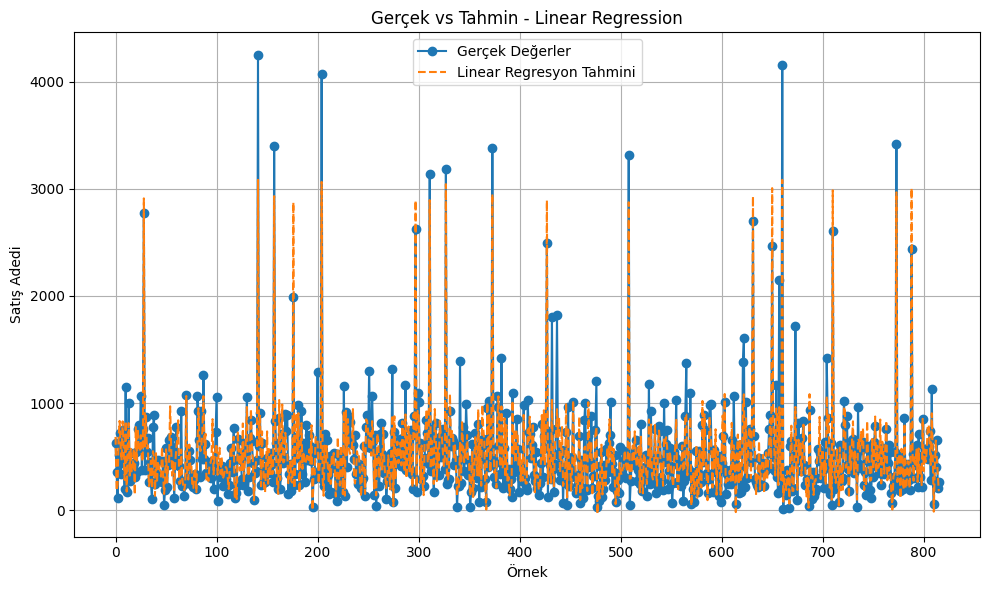

In [12]:
plt.figure(figsize=(10,6))
plt.plot(Y_test.values, label='Gerçek Değerler', marker='o')
plt.plot(Y_pred_lr, label='Linear Regresyon Tahmini', linestyle='--')
plt.title('Gerçek vs Tahmin - Linear Regression')
plt.xlabel('Örnek')
plt.ylabel('Satış Adedi')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Bir regresyon çalışması yapıldığı için en uygun metrikler mesafe tabanlı metrikler olur yani Ortalama Kare Hata(MSE), Ortalama Mutlak Hata(MAE) ve R2 Skor.

In [13]:
mse_lr = mean_squared_error(Y_test, Y_pred_lr)
mae_lr = mean_absolute_error(Y_test, Y_pred_lr)
r2_lr = r2_score(Y_test, Y_pred_lr)

print("Linear Regression Sonuçları")
print(f"Test MSE: {mse_lr:.2f}")
print(f"Test MAE: {mae_lr:.2f}")
print(f"Test R²: {r2_lr:.4f}")

Linear Regression Sonuçları
Test MSE: 34636.88
Test MAE: 123.91
Test R²: 0.8470


Random forest makine öğrenmesinin regresyon türü kullanıldı. Random forest, zaman serisi analizlerinde iyi olmasa da yapılan **tarih** özelliğini **yil** ve **ay** olarak ayırma gibi *özellik mühendisliği* ile uygun hale getirildi. Ayrıca random forest için grid search kullanılarak en iyi hiperparametreler bulundu. En iyi sonucu veren random forest ile test verisi üzerinde tahminlerde bulunuldu ve sonuçlar grafik ile gösterildi.

In [14]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, Y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=1)

En iyi parametreler: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
En iyi skor (R^2, cross-val): 0.8633323295563287


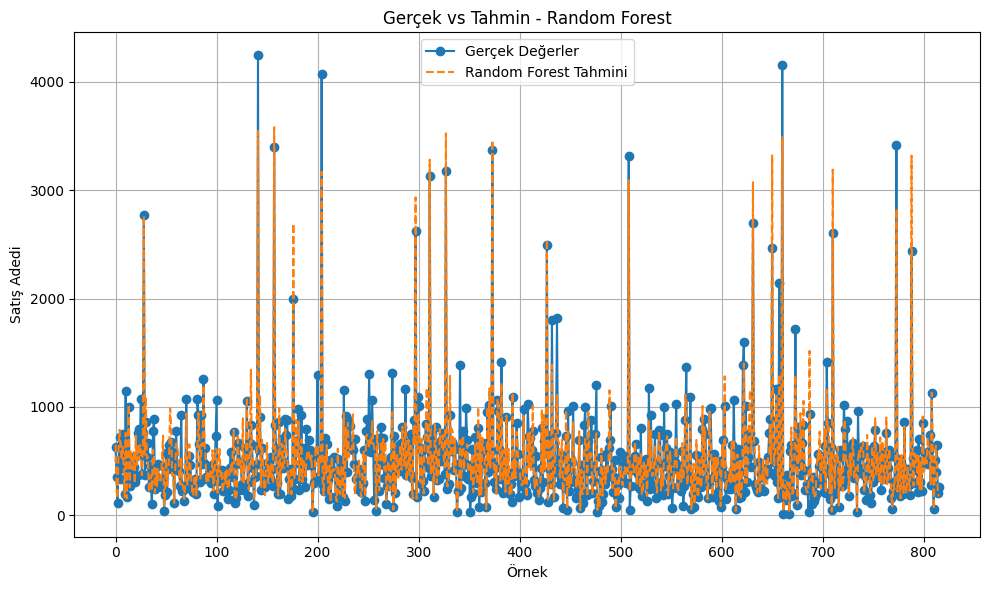

In [15]:
print("En iyi parametreler:", grid_rf.best_params_)
print("En iyi skor (R^2, cross-val):", grid_rf.best_score_)

Y_pred_rf = grid_rf.predict(X_test)

plt.figure(figsize=(10,6))
plt.plot(Y_test.values, label='Gerçek Değerler', marker='o')
plt.plot(Y_pred_rf, label='Random Forest Tahmini', linestyle='--')
plt.title('Gerçek vs Tahmin - Random Forest')
plt.xlabel('Örnek')
plt.ylabel('Satış Adedi')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Aynı şekilde regresyon çalışması yaptığımız için mesafe tabanlı metrikler kullanılmıştır.

In [16]:
mse_rf = mean_squared_error(Y_test, Y_pred_rf)
mae_rf = mean_absolute_error(Y_test, Y_pred_rf)
r2_rf = r2_score(Y_test, Y_pred_rf)

print('Random Forest Sonuçları')
print(f"Test MSE: {mse_rf:.2f}")
print(f"Test MAE: {mae_rf:.2f}")
print(f"Test R²: {r2_rf:.2f}")

Random Forest Sonuçları
Test MSE: 27873.40
Test MAE: 104.75
Test R²: 0.88


## LR VE RF MODELLERİNİN KARŞILAŞTIRILMASI

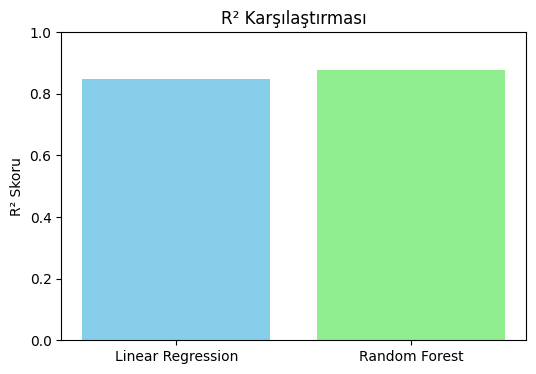

In [17]:
plt.figure(figsize=(6, 4))
plt.bar(['Linear Regression', 'Random Forest'], [r2_lr, r2_rf], color=['skyblue', 'lightgreen'])
plt.title('R² Karşılaştırması')
plt.ylabel('R² Skoru')
plt.ylim(0, 1)
plt.show()

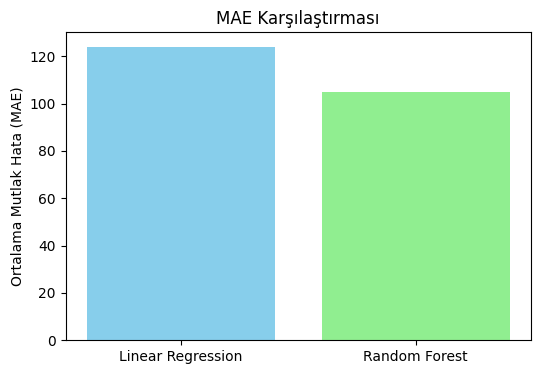

In [18]:
plt.figure(figsize=(6, 4))
plt.bar(['Linear Regression', 'Random Forest'], [mae_lr, mae_rf], color=['skyblue', 'lightgreen'])
plt.title('MAE Karşılaştırması')
plt.ylabel('Ortalama Mutlak Hata (MAE)')
plt.show()

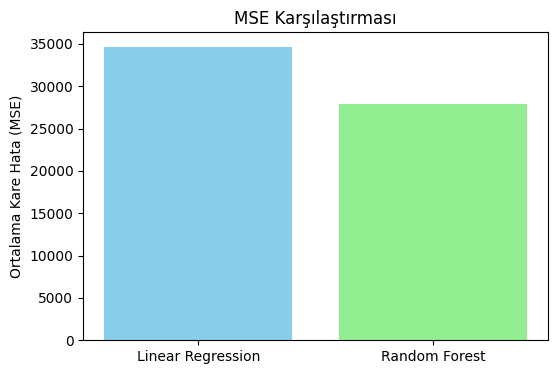

In [19]:
plt.figure(figsize=(6, 4))
plt.bar(['Linear Regression', 'Random Forest'], [mse_lr, mse_rf], color=['skyblue', 'lightgreen'])
plt.title('MSE Karşılaştırması')
plt.ylabel('Ortalama Kare Hata (MSE)')
plt.show()